---
# Single-cell protein abundance by marker localization

In [1]:
## logging functions
import logging
## data functions
import numpy as np
## data functions
import pandas as pd
## system functions
from os.path import dirname
## system functions
from os.path import exists
## system functions
from os.path import splitext
## system functions
import sys
import matplotlib.pyplot as plt
import seaborn as sns

## visualization functions from roux
from roux.viz.diagram import diagram_nb
## visualization functions from roux
from roux.viz.io import to_plot
## data functions from roux
import roux.lib.dfs as rd # attributes
from roux.lib.sys import basenamenoext
from roux.lib.io import to_table
sys.path.append('..')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
## parameters
input_path=None ## path to the image from channel marking a subcellular localization
output_path=None

image_intensity_path=None ## path to the image with channel which is to be used to caluculate the abundance
regions_path=None ## segmented regions (dtype: bool)
marker_intensity_min_quantile=0.975
pixels_per_cell_min=100
non_marker_intensity_quantile_off=0.02
background_intensity=None ## normalise

force=False
test=True

In [4]:
output_dir_path=dirname(output_path)
output_plots_dir_path=splitext(output_path)[0]+'_plots/'
logging.warning(output_dir_path)

if background_intensity is None:
    background_intensity=1
    logging.warning("background_intensity not provided; set to 1 i.e. no normalisation.")

assert exists(input_path), input_path
assert exists(image_intensity_path), image_intensity_path
assert exists(regions_path), regions_path

In [5]:
diagram_nb(
"""
graph LR;
    N1(["Raw images"])
        --> abundance["Protein abundance\nchannel"] & marker["Localization\nmarker channel"] & seg["Segmentation\n(based on\nDIC image)"] 
        seg
        --> segdabundancebymarker
        marker
        --> Filter1["Get pixels localized\nat the marker\nby applying\na threshold"] --> segdabundancebymarker["Protein abundance at\nthe marker's localization\nby applying segmentation"]
        abundance
        --> segdabundancebymarker
            --> norm1["Normalize\nby background"]
            --> compare0(["Comparison of\nprotein abundance\nbetween marker location\nand rest of the cell"])
"""
)

In [6]:
input_dir_path=dirname(input_path)
logging.info(f"Input directory={input_dir_path}")

In [7]:
## read the images
from htsimaging.lib.io import read_image
images={
    'regions':read_image(regions_path),
    'intensity':read_image(image_intensity_path),
    'marker':read_image(
        # f'{input_dir_path}/epi_red.npy',
        input_path,
    ),
    }

### Segment marker locations

Note: the red channel can have either ER or cytoplasm marker.

#### Threshold search

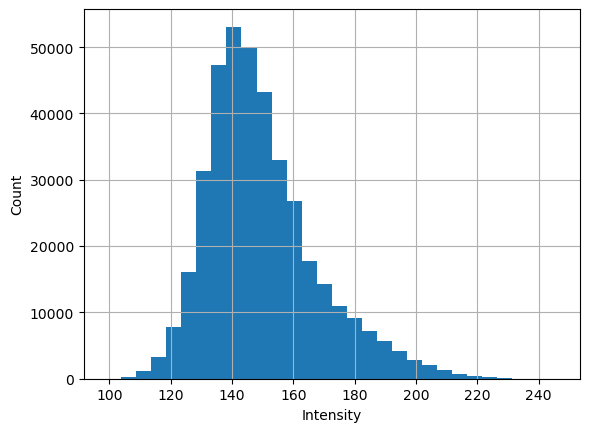

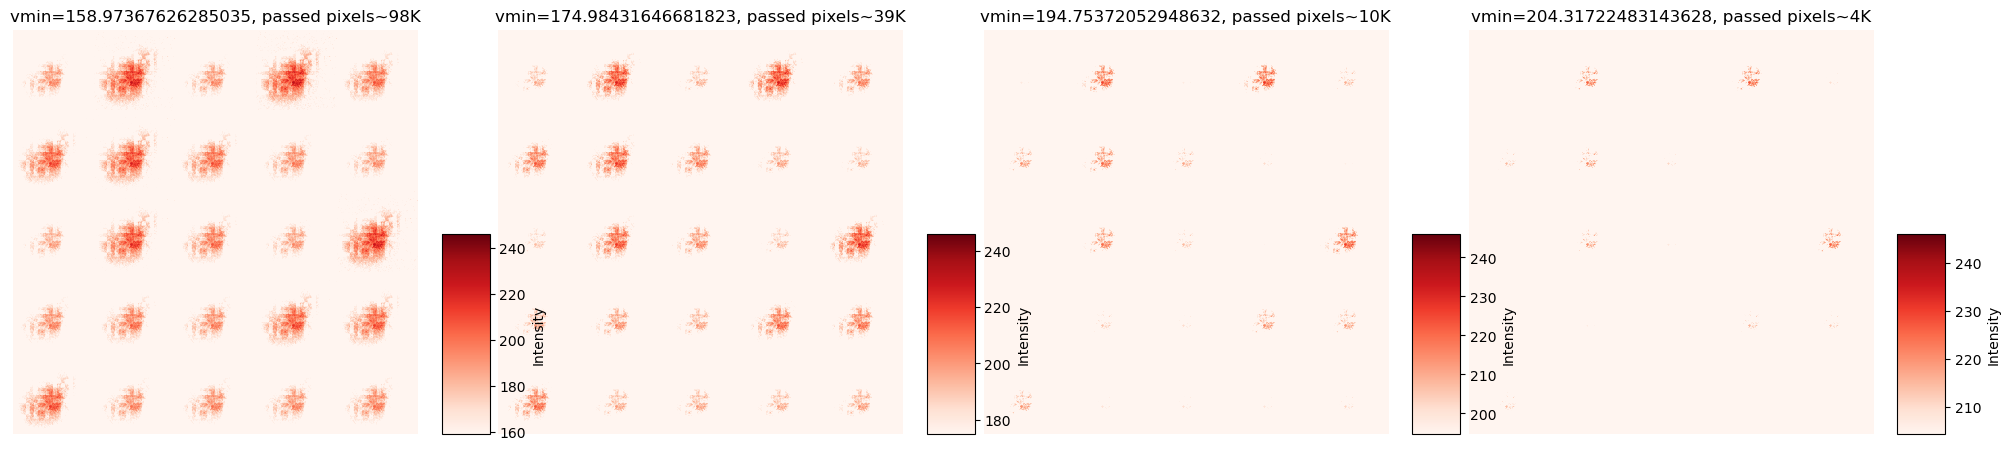

In [8]:
a1=images['marker'].copy()
plt.figure()
pd.Series(a1.ravel()).hist(bins=30).set(xlabel='Intensity',ylabel='Count')

from roux.lib.str import num2str
thresholds=[0.75,0.9,marker_intensity_min_quantile,0.99]
fig,axs=plt.subplots(1,len(thresholds),figsize=[6*len(thresholds),6])
for vmin_q,ax in zip(thresholds,axs):
    vmin=np.quantile(a1,vmin_q)
    if vmin_q==marker_intensity_min_quantile:
        marker_intensity_min=vmin
    from htsimaging.viz.image import image_background
    ax=image_background(
        img=a1[:800,:800],
        cmap='Reds',
        vmin=vmin,
        # vmax=vmax,
        ax=ax,
        )
    ax.axis(False)
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(title=f"vmin={vmin}, passed pixels~{num2str(sum(a1>=vmin).sum(),magnitude=True)}")

In [9]:
## mask the array
a2=a1.astype(float)
# a2[a2>=vmin] = np.nan ##
images['marker']=(a2>=marker_intensity_min)

In [10]:
images['no marker']=(a2<np.quantile(a1,marker_intensity_min_quantile-non_marker_intensity_quantile_off))

'/mnt/d/Documents/code/htsimaging/examples/protein_abundance_by_marker_location/01_gfpby_cell_and_marker_plots/image_marker_cells_segmentedby_marker.png'

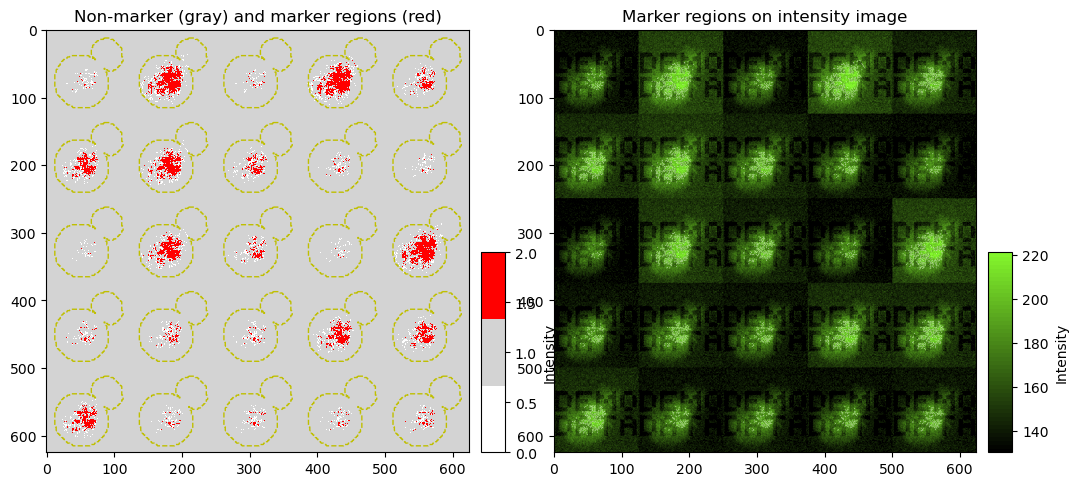

In [11]:
fig,axs=plt.subplots(1,2,figsize=[12,6])
from matplotlib.colors import ListedColormap
from htsimaging.viz.image import image_background
# Cell regions on thresholded marker image
# Non-marker regions on thresholded marker image
## create input array
_img=images['marker'][:800,:800].astype(float)
_img[_img == 1] = 2 # marker
_img+=images['no marker'][:800,:800].astype(float)
image_background(
    img=_img,
    # img=images['marker'][:800,:800],
    img_region=images['regions'][:800,:800],
    cmap = ListedColormap(["w","lightgray","r"]),
    alpha=1,
    linewidths=1,
    colors='y',
    kws_region={},
    show_scalebar=None,
    scalebar_color='w',
    test=False,
    ax=axs[0],
    )
axs[0].set(title="Non-marker (gray) and marker regions (red)")
# Marker regions on intensity image
image_background(
    img=images['intensity'][:800,:800],
    img_region=images['marker'][:800,:800],
    cmap='gfp',
    alpha=1,
    linewidths=0.2,
    colors='w',
    kws_region={},
    show_scalebar=None,
    scalebar_color='w',
    test=False,
    ax=axs[1],
    vmin=np.quantile(a1,0.1),
    vmax=np.quantile(a1,0.999),
    # **kws_img,
    )
axs[1].set(title="Marker regions on intensity image")

to_plot(f"{output_plots_dir_path}/{basenamenoext(input_path)}_segmentedby_marker.png")

### Apply the segmentation

In [12]:
df1=(pd.DataFrame({
    'cell id':images['regions'].ravel(),
    'intensity':images['intensity'].ravel(),
    'marker location':images['marker'].ravel(),
    'non-marker location':images['no marker'].ravel(),
    })
    .log.query(expr=f"`cell id` != 0") ## remove background
    .log.query(expr=f"`marker location` == True or `non-marker location` == True") ## remove unclassified pixels
    .drop(['non-marker location'],axis=1) 
    )
df1.head(1)

,cell id,intensity,marker location
8210,181.0,140.715396,False


In [13]:
## cell localization abundance
df2=(df1
    ## remove low number of pixels
    .log('cell id')
    .groupby(['cell id','marker location'])
        .filter(lambda df: len(df)>=pixels_per_cell_min)
        .reset_index()
    .log('cell id')
     
    ## remove no marker cells
    .groupby(['cell id'])
        .filter(lambda df: df['marker location'].any())
        .reset_index(0)
    .log('cell id')
   
    .groupby(['cell id','marker location'])
        .agg(
        **{
          # 'intensity mean':('intensity',np.mean),  
          'abundance':('intensity',np.median),
          'pixels':('intensity',len),
        }
        )
    .assign(
          **{
              'abundance normalized':lambda df: df['abundance']/background_intensity,
          }
    )
    # .add_prefix('intensity ')
    .reset_index()
    .rd.clean()
)
df2.head(1)

,cell id,marker location,abundance,pixels,abundance normalized
0,14.0,False,161.398111,103053,161.398111


[Text(0, 0.5, 'Cells'), Text(0.5, 0, 'Abundance normalized')]

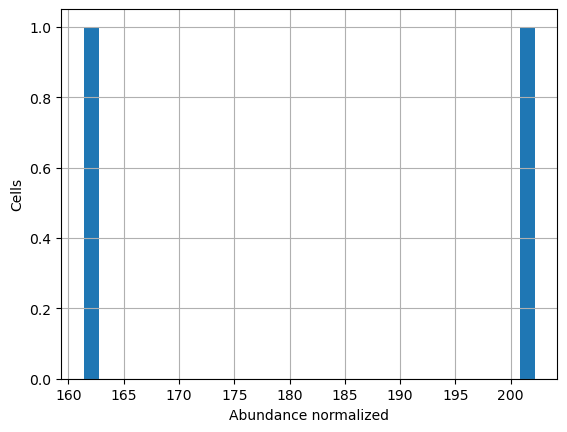

In [14]:
df2['abundance normalized'].hist(bins=30).set(xlabel='Abundance normalized',ylabel='Cells')

In [15]:
to_table(
    df2,
    output_path,
    )

'protein_abundance_by_marker_location/01_gfpby_cell_and_marker.tsv'

### Comparison of the protein abundance between the marker location and the rest of the cell

In [16]:
## difference between the 
df2.groupby('marker location')['abundance normalized'].median().diff()

marker location
False          NaN
True     40.805684
Name: abundance normalized, dtype: float64

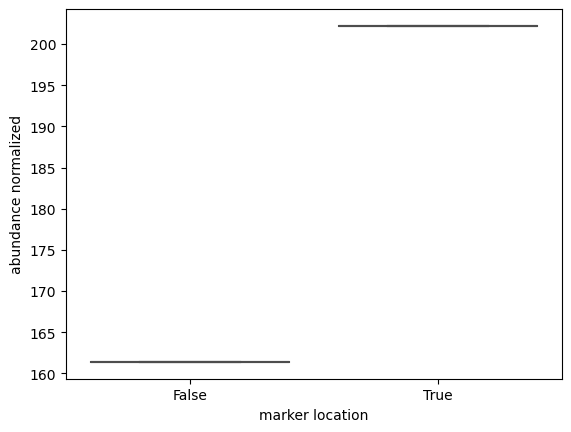

In [17]:
sns.boxplot(
    data=df2,
    y='abundance normalized',
    x='marker location',
    color='gray',
)